<a href="https://colab.research.google.com/github/Laurahg22/Trabajo-analitica-RH/blob/main/d_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importe de librerías

In [1]:
## Conectar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#### Cargar paquetes siempre al inicio
import pandas as pd ### para manejo de datos
import sqlite3 as sql #### para bases de datos sql
import sys ## saber ruta de la que carga paquetes
import numpy as np
import matplotlib.pyplot as plt ### gráficos

from sklearn import linear_model ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import get_scorer_names
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler ## escalar variables

import joblib  ### para guardar modelos
import openpyxl

sys.path ###Ruta directorio qué tiene paquetes
sys.path.append('/content/drive/MyDrive/trabajo/Trabajo-analitica-RH') ## este comanda agrega una ruta

import a_funciones as funciones  ###archivo de funciones propias

In [8]:
# Leer datos de 015
df2015 = pd.read_csv('/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/data/df2015.csv')
df2015

,Age,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,6,2,0,1,131160,1.0,11,0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,31,10,1,0,1,41890,0.0,23,1,6.0,...,0,0,0,0,1,0,0,0,0,1
2,32,17,4,1,4,193280,1.0,15,3,5.0,...,0,0,0,0,0,1,0,0,1,0
3,38,2,5,1,3,83210,3.0,11,3,13.0,...,0,0,0,0,0,0,0,0,1,0
4,32,10,1,1,1,23420,4.0,12,2,9.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,5,4,0,1,60290,3.0,17,1,10.0,...,0,0,0,0,1,0,0,0,0,1
4406,29,2,4,1,1,26790,2.0,15,0,10.0,...,1,0,0,0,0,0,0,1,0,0
4407,25,25,2,1,2,37020,0.0,20,0,5.0,...,0,0,0,0,0,1,0,0,1,0
4408,42,18,2,1,1,23980,0.0,14,1,10.0,...,1,0,0,0,0,0,0,1,0,0




## Escalado y/o estandarización de los datos

In [9]:
######## con base en los modelos candidatos se realizará una selección de variables ########
y = df2015['Attrition']
X1 = df2015.loc[:, ~df2015.columns.isin(['Attrition'])]
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

## Árbol de decisión

|--- TotalWorkingYears <= -1.26
|   |--- MonthlyIncome <= 1.01
|   |   |--- Age <= -1.14
|   |   |   |--- class: 1
|   |   |--- Age >  -1.14
|   |   |   |--- class: 0
|   |--- MonthlyIncome >  1.01
|   |   |--- WorkLifeBalance <= 1.05
|   |   |   |--- class: 0
|   |   |--- WorkLifeBalance >  1.05
|   |   |   |--- class: 1
|--- TotalWorkingYears >  -1.26
|   |--- MaritalStatus_Single <= 0.39
|   |   |--- NumCompaniesWorked <= 0.73
|   |   |   |--- class: 0
|   |   |--- NumCompaniesWorked >  0.73
|   |   |   |--- class: 0
|   |--- MaritalStatus_Single >  0.39
|   |   |--- Age <= -0.37
|   |   |   |--- class: 0
|   |   |--- Age >  -0.37
|   |   |   |--- class: 0



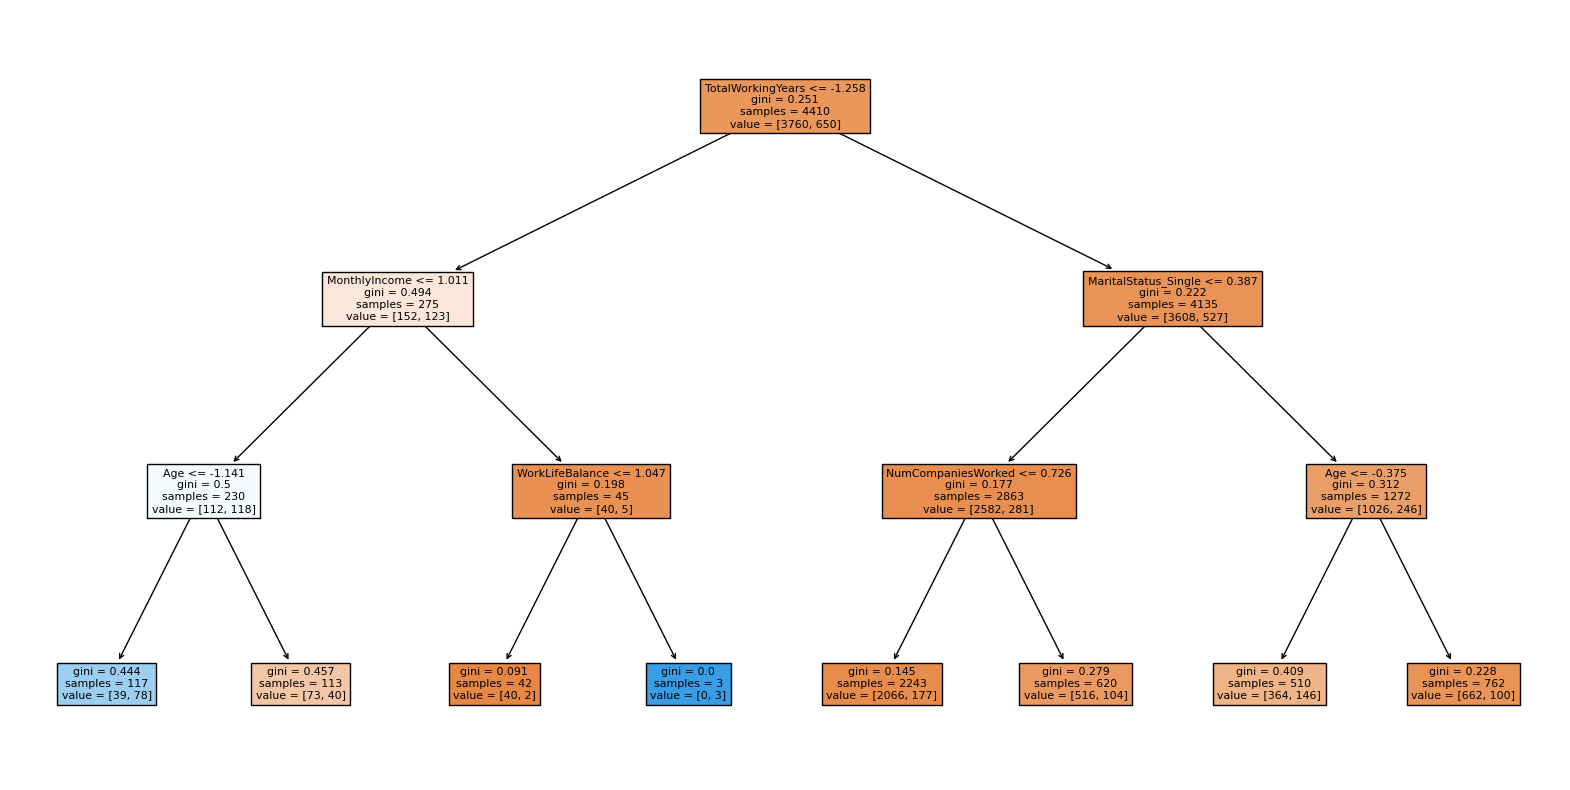

In [13]:
# Crear y entrenar el modelo de árbol de decisión
rtree = DecisionTreeClassifier(max_depth=3)
rtree.fit(X=X, y=y)

# Generar una representación de texto del árbol de decisión
tree_text = export_text(rtree, feature_names=X.columns.tolist())
print(tree_text)

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(rtree, feature_names=X.columns.tolist(), filled=True)
plt.show()

## Modelos candidatos

In [14]:
# Define los modelos seleccionados
m_logreg = LogisticRegression()
m_tree = DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

# Lista de modelos seleccionados
modelos=list([m_logreg,m_tree, m_rf, m_gbt])

## Selección de variables

In [30]:
# Ahora, utiliza estos modelos para seleccionar las variables
var_names = funciones.sel_variables(modelos, X, y, threshold="2.5*mean")
X2=X[var_names] ### matriz con variables sele ccionadas
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   EnvironmentSatisfaction  4410 non-null   float64
 3   JobSatisfaction          4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   PercentSalaryHike        4410 non-null   float64
 7   TotalWorkingYears        4410 non-null   float64
 8   YearsSinceLastPromotion  4410 non-null   float64
 9   YearsWithCurrManager     4410 non-null   float64
dtypes: float64(10)
memory usage: 344.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                    

Para la seleccion de variables utilizamos SelectFromModel y obtuvimos las variables anteriores, pasando de 43 variables explicativas a 10.



## Definir modelo ganador

In [36]:
# Calcular AUC-ROC para todos los modelos con todas las variables
f1score_df = funciones.medir_modelos(modelos, "f1", X, y, 30)
# Calcular AUC-ROC para todos los modelos con variables seleccionadas
f1_score_varsel = funciones.medir_modelos(modelos, "f1", X2, y, 30)

In [37]:
f1=pd.concat([f1score_df,f1_score_varsel],axis=1)
f1.columns=['rl', 'dt', 'rf', 'gb', 'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
f1

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.370370,0.975610,0.975610,0.625000,0.090909,0.975610,0.975610,0.500000
1,0.320000,1.000000,1.000000,0.580645,0.090909,1.000000,1.000000,0.580645
2,0.230769,0.975610,1.000000,0.482759,0.000000,0.975610,1.000000,0.533333
3,0.230769,1.000000,1.000000,0.645161,0.173913,1.000000,1.000000,0.551724
4,0.086957,1.000000,1.000000,0.173913,0.000000,1.000000,1.000000,0.307692
5,0.074074,1.000000,1.000000,0.600000,0.000000,1.000000,1.000000,0.444444
6,0.320000,1.000000,1.000000,0.687500,0.000000,0.975610,1.000000,0.500000
7,0.240000,1.000000,1.000000,0.600000,0.000000,1.000000,1.000000,0.230769
8,0.214286,0.551724,0.727273,0.370370,0.086957,0.551724,0.687500,0.296296
9,0.083333,0.000000,0.444444,0.090909,0.000000,0.000000,0.173913,0.166667


In [ ]:
f1score_df.plot(kind='box') #### gráfico para modelos todas las variables

In [ ]:
f1_score_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas

<Axes: >

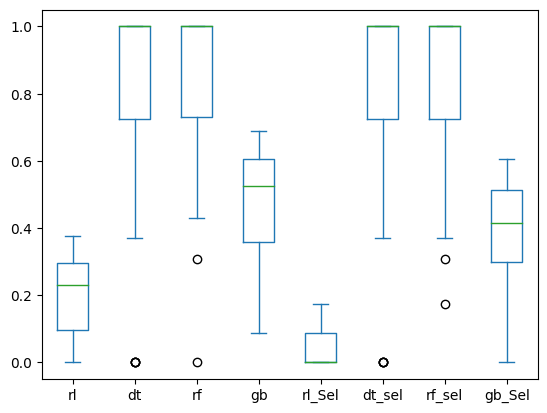

In [38]:
f1.plot(kind='box') ### gráfico para modelos sel y todas las variables

In [39]:
f1.mean()

rl        0.212993
dt        0.790158
rf        0.844578
gb        0.467928
rl_Sel    0.037703
dt_sel    0.788356
rf_sel    0.843251
gb_Sel    0.384251
dtype: float64

Dado que estamos abordando un problema de clasificación con desbalance de clases y considerando los problemas de negocio relacionados con la alta tasa de retiros de empleados, se requiere un modelo que pueda equilibrar la precisión y la exhaustividad en la predicción de los retiros. Los modelos Random Forest y Decision Tree han demostrado ser opciones efectivas en este tipo de problemas, ya que ofrecen un buen equilibrio entre precisión y exhaustividad, como lo demuestran sus altos puntajes de F1 score.

Además, consideramos el modelo con variables seleccionadas debido a su rendimiento comparable al modelo con todas las variables. Esto nos permite reducir la complejidad del modelo y el costo computacional sin comprometer significativamente el desempeño predictivo. Dado que nuestro objetivo es identificar las variables más influyentes en la tasa de retiros y pronosticar con precisión las salidas de los empleados, este enfoque nos proporciona una solución eficiente y efectiva para abordar nuestros problemas de negocio.

Finalmente, entrenaremos el modelo Ramdon Forest con las variables seleccionadas.



## Afinamiento de hiperparámetros

In [40]:
# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt'],  # Número de características a considerar en cada división
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas para estar en un nodo hoja
    'bootstrap': [True, False]  # Método de muestreo para construir árboles
}

In [42]:
# Técnica de búsqueda de hiperparámetros
tun_rf=RandomizedSearchCV(m_rf,param_distributions=param_grid,n_iter=6,scoring="f1")
tun_rf.fit(X2,y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=6,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='f1')

In [43]:
pd.set_option('display.max_colwidth', 100)
resultados=tun_rf.cv_results_
tun_rf.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
5,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'ma...",0.875220
3,"{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max...",0.853161
2,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'ma...",0.845368
4,"{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max...",0.835767
0,"{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max...",0.695019
1,"{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'ma...",0.573182


In [44]:
# Guardar el modelo con hyperparameter tunning
rf_final=tun_rf.best_estimator_

In [46]:
### función para exportar y guardar objetos de python (cualqueira)
joblib.dump(rf_final, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/rf_final.pkl") ##
#joblib.dump(list_cat, "salidas\\list_cat.pkl") ### para realizar imputacion
#joblib.dump(list_dummies, "salidas\\list_dummies.pkl")  ### para convertir a dummies
joblib.dump(var_names, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/scaler.pkl") ##

['/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/scaler.pkl']